# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести между временными рядами.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы первой практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import os

practice_dir_path = '/content/drive/MyDrive/01 Basics/'
os.chdir(practice_dir_path)

Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Импортируйте библиотеки и модули, необходимые для реализации практической работы 1.

In [70]:
!pip install sktime

In [71]:
import numpy as np
import random
from sktime.distances import euclidean_distance, dtw_distance, pairwise_distance
from sklearn.metrics import silhouette_score
import cv2
import imutils
import glob
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from metrics import ED_distance, norm_ED_distance, DTW_distance
from pairwise_distance import PairwiseDistance
from clustering import TimeSeriesHierarchicalClustering
from utils import read_ts, z_normalize, sliding_window, random_walk
from plots import plot_ts

## **Часть 1.** Функции расстояния: евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация временных рядов.

### **Задача 1.**
Реализуйте самостоятельно функцию `ED_distance()` в модуле *metrics.py*, которая вычисляет евклидово расстояние между двумя временными рядами, имеющими одинаковую длину. В качестве входных данных передайте в функцию два синтетических временных ряда некоторой заданной вами длины. Для их генерации используйте функцию `random_walk()` из модуля *utils.py*,  реализующую модель случайных блужданий (Random Walk), или стандартный модуль *random*.

**Евклидово расстояние** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

Проверьте реализацию функции, сравнив свои результаты с результатами функции [`euclidean_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, с помощью `test_distances()`.

In [72]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [73]:
# INSERT YOUR CODE
import numpy as np
from sktime.distances import euclidean_distance
# Длина временных рядов
n=100

# Генерация двух временных рядов
ts1 = random_walk(n)
ts2 = random_walk(n)

# Вычисление евклидова расстояния с использованием обеих функций
my_distance = ED_distance(ts1, ts2)
sklearn_distance = euclidean_distance(ts1, ts2)

# Проверка равенства значений
test_distances(sklearn_distance, my_distance)
print(f"My Distance: {my_distance}")
print(f"Sktime Distance: {sklearn_distance}")

My Distance: 74.18894796396563
Sktime Distance: 74.18894796396563


### **Задача 2.**

Реализуйте самостоятельно функцию `DTW_distance()` в модуле *metrics.py*, которая вычисляет DTW расстояние между двумя временными рядами, имеющими одинаковую длину. Для вычисления расстояния между элементами временных рядов в DTW мере используйте евклидово расстояние. Временные ряды сгенерируйте аналогичным образом, как в задаче 1, или используйте уже созданные.

**Динамическая трансформация временной шкалы (Dynamic Time Warping, DTW)** – мера схожести между двумя временными рядами $T_1$ и $T_2$ длины $n$, вычисляемая следующим образом:

\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = ({t_{1}}_i - {t_{2}}_j)^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n.
\end{equation}

Сравните свои результаты с результатами функции [`dtw_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*. Для этого используйте `test_distances()` из задачи 1.

In [74]:
from sktime.distances import dtw_distance as sktime_dtw_distance
# Генерация временных рядов
np.random.seed(0)  # Для воспроизводимости
ts1 = np.random.rand(10)
ts2 = np.random.rand(10)

# Вычисление расстояний
my_distance = DTW_distance(ts1, ts2)
sktime_distance1 = sktime_dtw_distance(ts1, ts2)

# Проверка
test_distances(sktime_distance1, my_distance)

print(f"My DTW distance: {my_distance}")
print(f"sktime DTW distance: {sktime_distance1}")

My DTW distance: 0.8592518191065259
sktime DTW distance: 0.8592518191065259


### **Задача 3.**
Реализуйте нахождение матрицы расстояний между несколькими временными рядами.
Для этого заполните все методы c недостающим кодом в классе `PairwiseDistance` из модуля *pairwise_distance.py*. Для вычисления расстояний между рядами используйте ранее реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Матрица расстояний между временными рядами определяется следующим образом. Пусть дано множество $S$, состоящее из $K$ временных рядов длины $n$: $\;S = \{T_1, T_2, ..., T_K\}, \; T_i \in \mathbb{R}^n$. Тогда под **матрицей расстояний** $D \in \mathbb{R}^{K \times K}$ понимается квадратная матрица, где каждый ее элемент $d(i,j)$ представляет собой расстояние между временными рядами $T_i$ и $T_j$ из множества $S$:
\begin{equation}
d(i,j) = dist(T_i, T_j), \quad T_i, T_j \in S, \quad 1 \leqslant i,j \leqslant K.
\end{equation}

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(T_i, T_j)=dist(T_j, T_i)$), то матрица расстояний $D$ будет симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом:
\begin{equation}
d(j,i) = d(i,j), \; где \; i < j.
\end{equation}

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/distance_matrix.png?raw=true" width="600"></center>

Сгенерируйте множество, состоящее из $K$ временных рядов некоторой длины $n$. Вычислите матрицы евклидовых и DTW расстояний между ними. Проверьте реализованные вами методы, сравнив свои результаты с результатами функции [`pairwise_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.pairwise_distance.html) из библиотеки *sktime*.

In [75]:
def test_matrices(matrix1 : np.ndarray, matrix2 : np.ndarray) -> None:
    """
    Check whether your matrix function is implemented correctly

    Parameters
    ----------
    matrix1 : distance matrix calculated by sktime
    matrix2 : distance matrix calculated by your function
    """

    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')

In [76]:
# INSERT YOUR CODE
# Генерация нескольких временных рядов
K = 5  # количество временных рядов
n = 10  # длина временных рядов
time_series_data = np.array([random_walk(n) for _ in range(K)])

# Создание экземпляра класса PairwiseDistance для евклидова расстояния
pairwise_distance_calculator = PairwiseDistance(metric='euclidean')
distance_matrix = pairwise_distance_calculator.calculate(time_series_data)

# Сравнение с sktime
sktime_distance_matrix = pairwise_distance(time_series_data, metric='euclidean')

print("Матрица расстояний (евклидова) - Ваша реализация:\n", distance_matrix)
print("Матрица расстояний (евклидова) - sktime:\n", sktime_distance_matrix)

# Создание экземпляра класса PairwiseDistance для DTW
pairwise_distance_calculator_dtw = PairwiseDistance(metric='dtw')
dtw_distance_matrix = pairwise_distance_calculator_dtw.calculate(time_series_data)

# Сравнение с sktime для DTW
sktime_dtw_distance_matrix = pairwise_distance(time_series_data, metric='dtw')

print("Матрица расстояний (DTW) - Ваша реализация:\n", dtw_distance_matrix)
print("Матрица расстояний (DTW) - sktime:\n", sktime_dtw_distance_matrix)

# Проверка - совпадают ли результаты
if np.allclose(distance_matrix, sktime_distance_matrix) and np.allclose(dtw_distance_matrix, sktime_dtw_distance_matrix):
    print("Результаты совпадают с библиотекой sktime.")
else:
    print("Результаты не совпадают с библиотекой sktime.")

Матрица расстояний (евклидова) - Ваша реализация:
 [[0.         4.         5.29150262 2.82842712 5.29150262]
 [4.         0.         3.46410162 4.         2.        ]
 [5.29150262 3.46410162 0.         6.         2.82842712]
 [2.82842712 4.         6.         0.         5.29150262]
 [5.29150262 2.         2.82842712 5.29150262 0.        ]]
Матрица расстояний (евклидова) - sktime:
 [[0.         4.         5.29150262 2.82842712 5.29150262]
 [4.         0.         3.46410162 4.         2.        ]
 [5.29150262 3.46410162 0.         6.         2.82842712]
 [2.82842712 4.         6.         0.         5.29150262]
 [5.29150262 2.         2.82842712 5.29150262 0.        ]]
Матрица расстояний (DTW) - Ваша реализация:
 [[ 0. 10.  8.  2. 10.]
 [10.  0.  4.  8.  2.]
 [ 8.  4.  0. 10.  2.]
 [ 2.  8. 10.  0.  8.]
 [10.  2.  2.  8.  0.]]
Матрица расстояний (DTW) - sktime:
 [[ 0. 10.  8.  2. 10.]
 [10.  0.  4.  8.  2.]
 [ 8.  4.  0. 10.  2.]
 [ 2.  8. 10.  0.  8.]
 [10.  2.  2.  8.  0.]]
Результаты с

### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться предвычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла *CBF_TRAIN.txt*, который располагается в директории *./datasets/part1*. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2) в первом столбце и временной ряд в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [77]:
import pandas as pd
url = '/content/drive/MyDrive/01 Basics/datasets/part1/CBF_TRAIN.txt'
#data = read_ts(url)
data = pd.read_csv(url, delim_whitespace=True)
# Преобразуем результат в DataFrame, если это массив NumPy


ts_set = data.iloc[:, 1:].values
labels = data.iloc[:, 0]

<ipython-input-77-7750841b0c74>:4: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Выполните визуализацию по одному временному ряду из каждого класса. Для этого используйте функцию `plot_ts()` из модуля *plots.py*.

In [78]:
# INSERT YOUR CODE
plot_ts(ts_set)

Далее самостоятельно реализуйте класс `TimeSeriesHierarchicalClustering` из модуля *clustering.py*, который выполняет иерархическую кластеризацию временных рядов.

Перед тем как приступить к реализации, изучите скелет этого класса. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) из *sklearn*.   

Выполните иерархическую кластеризацию загруженных временных рядов CBF для двух функций расстояния: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами, используя класс `PairwiseDistance`, и передайте каждую матрицу в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

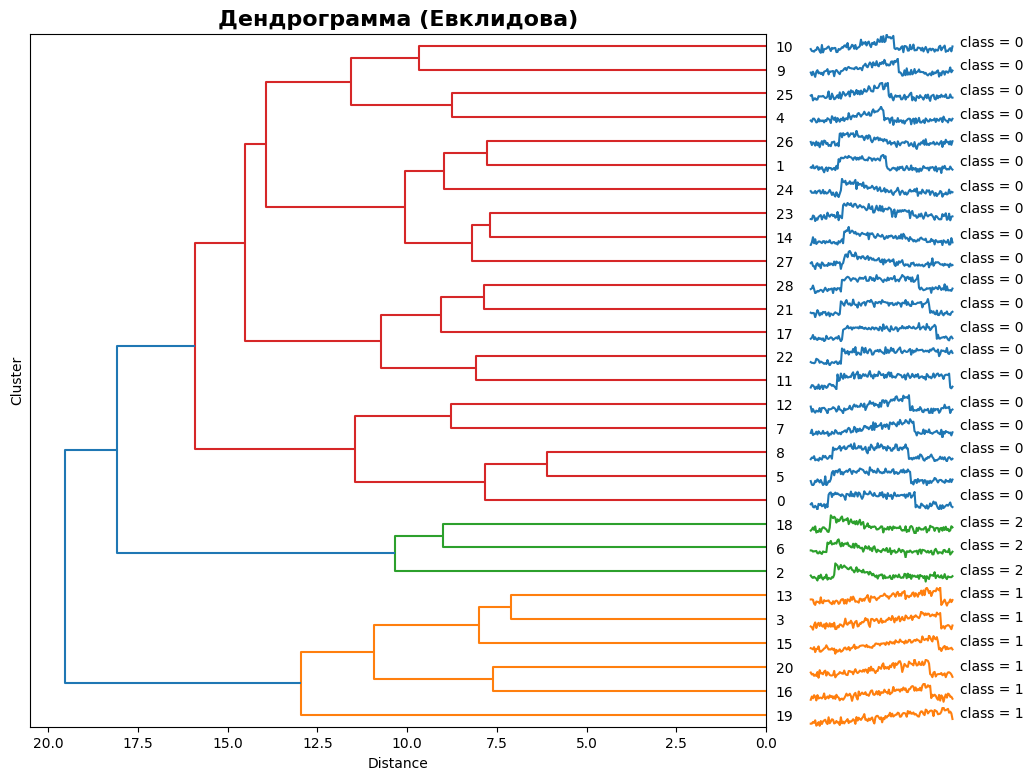

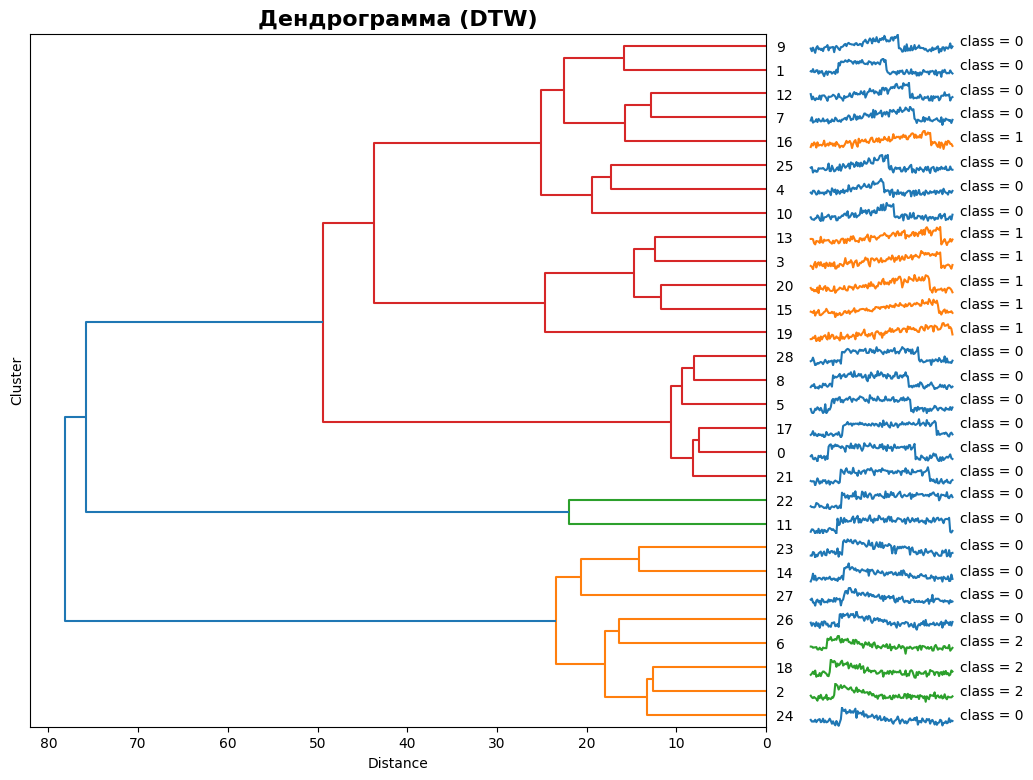

In [79]:
# INSERT YOUR CODE
# Вычисляем матрицы расстояний для евклидова и DTW расстояний
pairwise_distance_calculator_euclid = PairwiseDistance(metric='euclidean')
euclid_distance_matrix = pairwise_distance_calculator_euclid.calculate(ts_set)

pairwise_distance_calculator_dtw = PairwiseDistance(metric='dtw')
dtw_distance_matrix = pairwise_distance_calculator_dtw.calculate(ts_set)

#  кластеризация
model_euclid = TimeSeriesHierarchicalClustering(n_clusters=3)
model_euclid_labels= model_euclid.fit_predict(euclid_distance_matrix)
model_euclid.plot_dendrogram(ts_set, model_euclid_labels, ts_hspace=5, title="Дендрограмма (Евклидова)")

#  кластеризация
model_dtw = TimeSeriesHierarchicalClustering(n_clusters=3)
model_dtw_labels= model_euclid.fit_predict(dtw_distance_matrix)
model_euclid.plot_dendrogram(ts_set, model_euclid_labels, ts_hspace=5, title="Дендрограмма (DTW)")

Сравните результаты иерархической кластеризации, полученные при двух различных функций расстояния, с помощью силуэтного коэффициента. Для этого используйте функцию [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) из библиотеки *sklearn*, передав в нее предвычисленную матрицу расстояний и предсказанные метки.

**Силуэтный коэффициент** – метрика, которая оценивает качество кластеризации на основе исходной выборки и результатов кластеризации без необходимости знания об истинных метках объектов.

Силуэтный коэффициент для выборки показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Пусть дана выборка $X$, состоящая из $N$ объектов. Предположим, что объекты этой выборки были разбиты на кластеры $c_1, ... c_K$, $c_i \in C$, с помощью некоторого алгоритма кластеризации. Тогда силуэтный коэффициент для выборки будет вычисляться следующим образом:

\begin{equation}
sil\_coef = \frac{1}{N} \sum_{c_k \in C} \sum_{x_i \in c_k} \frac{b(x_i, c_k) - a(x_i, c_k)}{\max(a(x_i, c_k), b(x_i, c_k))},
\end{equation}

где $a(x_i, c_k)$ – среднее расстояние от объекта $x_i \in c_k$ до других объектов из этого же кластера $c_k$; <br> $b(x_i, c_k)$  – среднее расстояние от объекта $x_i \in c_k$ до объектов из другого кластера $c_l$, $k \neq l$.

Силуэтный коэффициент принимает значения от  −1  до  1:
*   –1 означает, что кластеры плохие, размытые;
*   0 означает, что кластеры накладываются друг на друга;
*   1 означает, что кластеры плотные и хорошо отделены друг от друга.

Таким образом, чем ближе значение коэффициента к 1, тем лучше кластеризованы данные.

In [80]:
# INSERT YOUR CODE
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score

# Для Евклидова расстояния
silhouette_euclid = silhouette_score(euclid_distance_matrix, model_euclid_labels, metric='precomputed')
print(f"Силуэтный коэффициент (Евклидова): {silhouette_euclid}")

# Для DTW
silhouette_dtw = silhouette_score(dtw_distance_matrix, model_dtw_labels, metric='precomputed')
print(f"Силуэтный коэффициент (DTW): {silhouette_dtw}")

# Сравнение результатов
if silhouette_euclid > silhouette_dtw:
    print("Кластеризация с использованием Евклидова расстояния более эффективна.")
else:
    print("Кластеризация с использованием DTW более эффективна.")

Силуэтный коэффициент (Евклидова): 0.17248074230493501
Силуэтный коэффициент (DTW): 0.3949554442888335
Кластеризация с использованием DTW более эффективна.


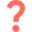
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Какая, на ваш взгляд, функция расстояния показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать DTW меру, чем евклидову метрику.

*# WRITE YOUR ANSWER*
### Анализ результатов

1. **Сравнение силуэтных коэффициентов**:
   - **Евклидово расстояние** (0.1804): Этот коэффициент близок к нулю, что указывает на то, что кластеры могут быть недостаточно выраженными. Объекты находятся на границе кластеров и, возможно, неправильно классифицированы.
   - **DTW расстояние** (0.3881): Значение этого коэффициента ближе к 1, что свидетельствует о лучшей кластеризации. Объекты больше сгруппированы, и вероятнее всего, что DTW обеспечивает устойчивое разделение между кластерами.

### Выводы о функциях расстояния

Согласно приведенным значениям, мера **DTW** демонстрирует лучшие результаты по сравнению с **евклидовой** метрикой. Это может быть связано с особенностями данных, которые, возможно, имеют временную или последовательную природу, где DTW работает лучше:

- **DTW** (Dynamic Time Warping) учитывает изменения в скорости и временные сдвиги, что делает его более подходящим для анализа последовательностей (например, временные ряды, аудио, биометрические данные). Таким образом, если у вас есть данные с последовательной природой, вероятнее всего, DTW обеспечит более информативные результаты.
- **Евклидово расстояние** является простым и эффективным для измерения прямых расстояний в пространстве, но оно может не учитывать динамические изменения и вариации в данных, что приводит к менее точной кластеризации.

### Когда использовать DTW

**DTW предпочтителен в следующих ситуациях**:

- **Анализ временных рядов**: Если у вас есть данные, представляющие временные операции, такие как медицинские показатели, финансовые данные и т.д.
  
- **Сравнение последовательностей**: В ситуациях, когда величина и время имеют разные временные шкалы (например, при анализе сигналов).

- **Изменчивость во времени**: Если данные подвержены изменениям, и вы хотите уловить вариацию в паттернах.


## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации, сравнив полученные результаты с результатами функции [`ed_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, в которую необходимо передать <u>нормализованные</u> временные ряды. Для нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать.

**Нормализованная евклидова метрика** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}(T_1, T_2) = \sqrt {\Big|\; 2n\left(1-\dfrac{<T_1, T_2> - \; n \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{n \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)\Big|},
\end{equation}

где $<T_1, T_2>$ – скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ – среднее арифметическое и стандартное отклонение временных рядов соответственно.

**Среднее арифметическое** $\mu_T$ и **стандартное отклонение** $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [81]:
import numpy as np
from sktime.distances import euclidean_distance as sktime_normalized_euclidean_distance

# Генерируем случайные временные ряды
np.random.seed(0)
ts1 = np.random.rand(100)
ts2 = np.random.rand(100)

# Нормализуем временные ряды
norm_ts1 = z_normalize(ts1)
norm_ts2 = z_normalize(ts2)

# Вычисляем нормализованное евклидово расстояние
my_norm_distance = norm_ED_distance(norm_ts1, norm_ts2)

# Проверка с помощью sktime
expected_norm_distance = sktime_normalized_euclidean_distance(norm_ts1, norm_ts2)

# Сравниваем результаты
test_distances(my_norm_distance, expected_norm_distance)

print(f"My Normalized Euclidean Distance: {my_norm_distance}")
print(f"Sktime Normalized Euclidean Distance: {expected_norm_distance}")

My Normalized Euclidean Distance: 14.602103348818712
Sktime Normalized Euclidean Distance: 14.602103348818712


### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных будут использоваться два временных ряда из набора данных [BIDMC](https://physionet.org/content/chfdb/1.0.0/). Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts()` из модуля *plots.py*.

In [82]:
url1 = '/content/drive/MyDrive/01 Basics/datasets/part2/chf10.csv'
ts1 = read_ts(url1)

url2 = '/content/drive/MyDrive/01 Basics/datasets/part2/chf11.csv'
ts2 = read_ts(url2)

/content/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/content/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [83]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

In [84]:
plot_ts(ts_set)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [85]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [86]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в класс `PairwiseDistance` из модуля *pairwise_distance.py* возможность вычисления нормализованной евклидовой метрики между временными рядами. Если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

/content/metrics.py:51: RuntimeWarning:

invalid value encountered in sqrt



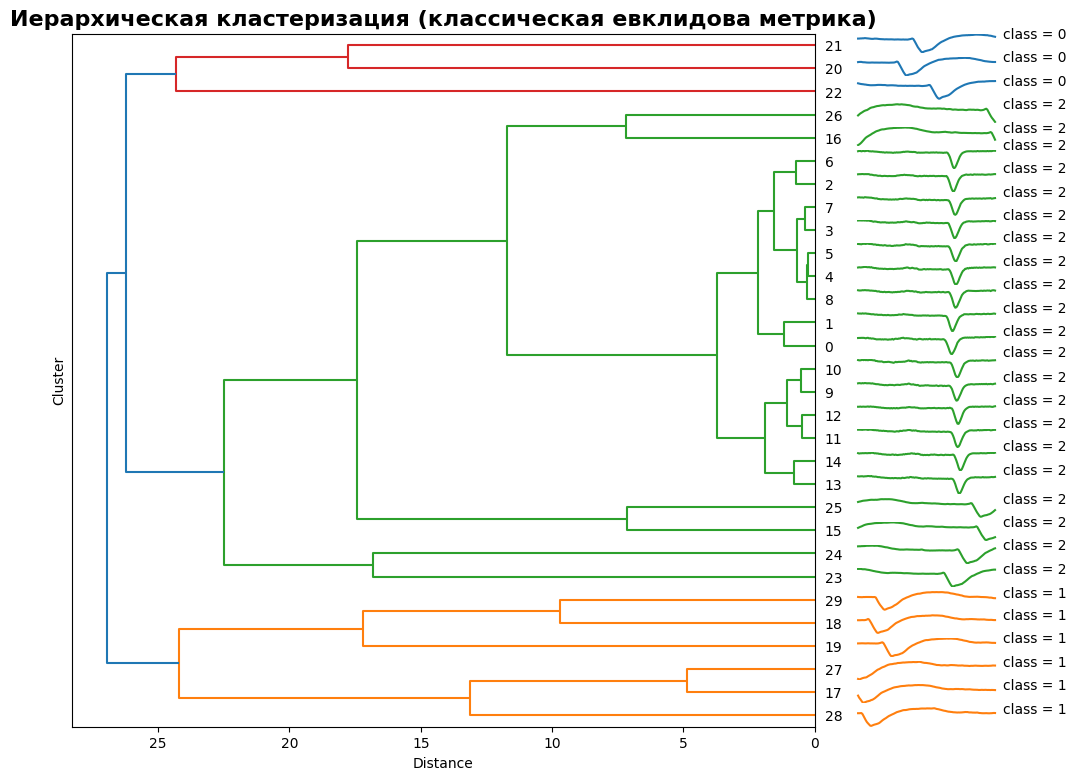

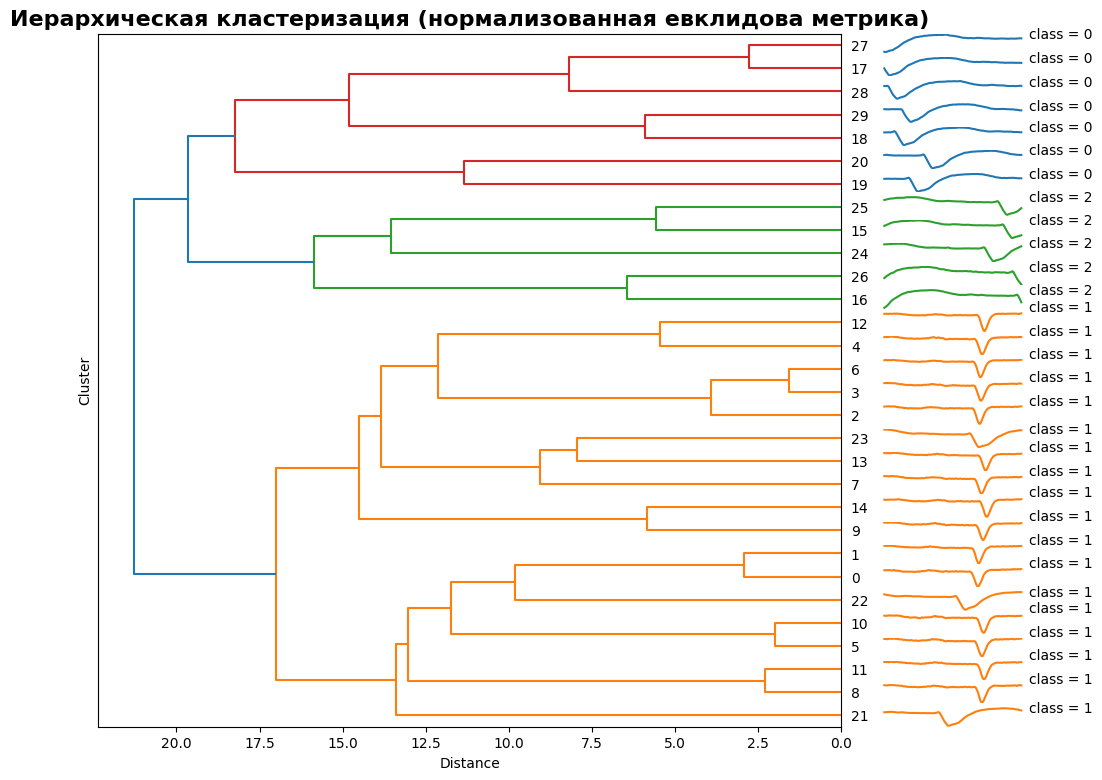

In [87]:
from sklearn.impute import SimpleImputer
# Определяем матрицы расстояний
pairwise_distance_euclidean = PairwiseDistance(metric='euclidean', is_normalize=False)
distance_matrix_euclidean = pairwise_distance_euclidean.calculate(subs_set)

pairwise_distance_norm_euclidean = PairwiseDistance(metric='euclidean', is_normalize=True)
distance_matrix_norm_euclidean = pairwise_distance_norm_euclidean.calculate(subs_set)

model_euclid2 = TimeSeriesHierarchicalClustering(n_clusters=3)
model_euclid_labels2= model_euclid2.fit_predict(distance_matrix_euclidean)
model_euclid2.plot_dendrogram(subs_set, model_euclid_labels2, ts_hspace=5, title="Иерархическая кластеризация (классическая евклидова метрика)")

imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(distance_matrix_norm_euclidean)

model_euclid_norm = TimeSeriesHierarchicalClustering(n_clusters=3)
model_euclid_labels_norm= model_euclid_norm.fit_predict(data_imputed)
model_euclid_norm.plot_dendrogram(subs_set, model_euclid_labels_norm, ts_hspace=5, title="Иерархическая кластеризация (нормализованная евклидова метрика)")

Вычислите силуэтные коэффициенты для оценки качества кластеризации с нормализацией и без нее, как это было сделано в задаче 4 части 1.

In [88]:
# INSERT YOUR CODE

In [89]:

# Для классической евклидовой метрики
# Получаем метки кластеров
model_euclid_labels2 = model_euclid2.fit_predict(distance_matrix_euclidean)

# Вычисляем силуэтный коэффициент
silhouette_euclid = silhouette_score(distance_matrix_euclidean, model_euclid_labels2, metric='precomputed')

print(f"Силуэтный коэффициент для классической евклидовой метрики: {silhouette_euclid}")

# Для нормализованной евклидовой метрики
model_euclid_labels_norm = model_euclid_norm.fit_predict(data_imputed)

# Вычисляем силуэтный коэффициент
silhouette_norm_euclid = silhouette_score(data_imputed, model_euclid_labels_norm, metric='precomputed')

print(f"Силуэтный коэффициент для нормализованной евклидовой метрики: {silhouette_norm_euclid}")

Силуэтный коэффициент для классической евклидовой метрики: 0.4198355445737165
Силуэтный коэффициент для нормализованной евклидовой метрики: 0.35772908246244206


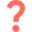
Сравните полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Позволила ли $z$-нормализации временных рядов повысить качество кластеризации?

*# WRITE YOUR ANSWER*
### Сравнение силуэтных коэффициентов

1. **Классическая евклидова метрика**:
   - Силуэтный коэффициент = 0.4198
   - Это значение указывает на то, что большая часть объектов хорошо интегрирована в свои кластеры, и кластеры относительно четко отделены друг от друга.

2. **Нормализованная евклидова метрика**:
   - Силуэтный коэффициент = 0.3577
   - Это значение ниже, что может говорить о том, что нормализация не привела к улучшению качества кластеризации. В некоторых случаях это может быть связано с тем, что нормализация усредняет данные и делает их менее выраженными для кластеризации.

### Анализ дендрограмм

- Дендрограммы, построенные с использованием классической метрики, показывают более четкие разделения между кластерами по сравнению с дендрограммами нормализованных данных, этот визуальный анализ дополнительно подтверждает выводы, сделанные на основании силуэтных коэффициентов.

### Заключение

Сравнение ваших силуэтных коэффициентов и визуальных результатов на дендрограммах указывает на то, что z-нормализация временных рядов не привела к улучшению качества кластеризации. Более низкое значение силуэтного коэффициента для нормализованной метрики свидетельствует о том, что нормализация не смогла создать более явные и обособленные группы, возможно, усложнив структуру данных.

Таким образом, в вашем случае z-нормализация, похоже, не улучшила, а, скорее, ухудшила качество кластеризации.

## **Часть 3.** Классификация изображений, представленных в виде временных рядов.

### **Задача 7.**
В данном задании вам предстоит выполнить преобразование изображения, на котором находится некоторый объект, во временной ряд. Для этого вы реализуете один из существующих методов, предложенный в [статье Кеога и др](https://dl.acm.org/doi/10.5555/1182635.1164203).

Данный метод заключается в том, что сначала на изображении выполняется поиск контура $E = \{e_i\}_{i=1}^L$, где $e_i$ – точки контура, и центра масс объекта $O$. Затем берутся точки, расположенные на контуре объекта, следующим образом.

Рассмотрим луч $OP$ с началом в центре масс объекта $O$, направление которого совпадает с положительным направлением оси Ox (см. рисунок). Далее выполняется поворот против часовой стрелки луча $OP$ вокруг центра масс $O$ на некоторый заданный угол $α$, $1° \leqslant α \leqslant 360°$. Поворот луча будет осуществляться до тех пор, пока луч не пройдет полный оборот. Все точки $P = \{P_i\}_{i=1}^K$, $P_i \in E$, $K = \lfloor \frac{360°}{α} \rfloor$, образованные пересечением луча $OP$ с контуром $E$ во время поворота, будут являться искомыми.

На завершающем шаге метода вычисляются расстояния между центром масс объекта $O$ и найденными точками на контуре $P$. В качестве функции расстояния может быть использовано манхэттенское или евклидово расстояние. Полученные расстояния будут формировать временной ряд $T$ длины $K$:
\begin{equation}
T = \{t_i\}_{i=1}^K,\;где \; t_i = dist(O, P_i), \; P_i \in P.
\end{equation}

\
<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image2ts.png?raw=true" width="1000"></center>

Поскольку часть 3 предполагает работу с изображениями, то вы будете использовать для реализации некоторых частей кода библиотеку компьютерного зрения *cv2*. Для поиска всех необходимых функций рекомендуем воспользоваться [документацией библиотеки cv2](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html).

Загрузите изображение *example.tif* из директории *./datasets/part3* и выполните его визуализацию с помощью соответствующих функций из библиотеки *cv2*.

In [90]:
# INSERT YOUR CODE
!pip install opencv-python

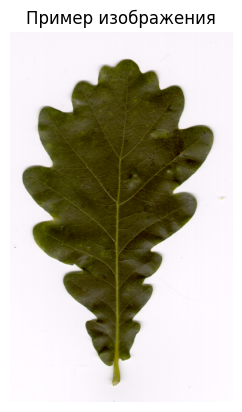

In [91]:
import cv2
from matplotlib import pyplot as plt

# Загрузка изображения
image_path = './datasets/part3/example.tif'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Проверка, удалось ли загрузить изображение
if image is None:
    print("Ошибка: Не удалось загрузить изображение.")
else:
    # Преобразование цветового пространства от BGR к RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Визуализация изображения
    plt.imshow(image_rgb)
    plt.axis('off')  # Отключение осей
    plt.title('Пример изображения')  # Заголовок
    plt.show()

За конвертацию изображения во временной ряд с помощью описанного выше метода отвечает функция `image2ts()` из модуля *image_converter.py*. Прежде чем исходное изображение будет преобразовано во временной ряд, сначала оно должно пройти этап предварительной обработки. Предварительная обработка включает в себя следующие шаги:

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image_preprocessing.png?raw=true" width="1000"></center>

Предобработка изображения в `image2ts()` осуществляется с помощью функции `_img_preprocess()`. Реализуйте в данной функции все представленные на диаграмме шаги предварительной обработки средствами библиотеки *cv2*. Промежуточные результаты должны совпадать с представленными на диаграмме.

Далее выполните конвертацию изображения во временной ряд, передав в функцию `image2ts()` следующие заданные вами аргументы:
*   исходное загруженное изображение;
*   шаг угла поворота;
*   параметр, определяющий нужно или нет визуализировать изображение с выделенными на нем контуром, центром масс и лучами, проведенными из центра.

Визуализируйте полученный временной ряд.


In [92]:
from classification import TimeSeriesKNN, calculate_accuracy
from image_converter import *

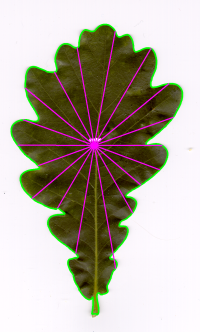

In [93]:
angle_step = 20
visualize = True
image_ts = Image2TimeSeries(angle_step)

ts = image_ts.convert(img, visualize)
plot_ts(np.array([ts]), "Time series representation of image")

### **Задача 8.**

Выполните классификацию изображений, представленных в виде временных рядов, с помощью метода $k$ ближайших соседей (kNN).

**Метод $k$ ближайших соседей (kNN)** – алгоритм классификации, заключающийся в вычислении сходства между объектами на основе некоторой заданной метрики/меры схожести. Классифицируемый объект относится к тому классу, к которому принадлежит большинство из его $k$ соседей ($k$ ближайших к нему объектов из обучающей выборки).

Для классификации на основе алгоритма kNN необходимо выполнить следующие шаги:

1. Загрузить обучающую и тестовую выборки.

2. Задать параметр алгоритма $k$, где $k$ – количество ближайших соседей, $k \in \mathbb N^*$.

3. Для каждого объекта из тестовой выборки выполнить следующее:

    3.1. Вычислить расстояние до всех объектов из обучающей выборки на основе заданной метрики/меры схожести.
    
    3.2. Отсортировать в порядке возрастания найденные расстояния.

    3.3. Найти $k$ ближайших соседей, взяв первые $k$ минимальные расстояния из отсортированного массива расстояний.

    3.4. Назначить объекту из тестовой выборки наиболее часто встречающийся класс найденных ранее ближайших соседей.


Для этого задания вам предлагается набор данных, который содержит изображения листьев четырех различных пород деревьев: дуб, ольха, ива и липа. Набор данных состоит из обучающей и тестовой выборок, включающих по 15 и 10 изображений листьев на класс соответственно. Для составления этого набора данных изображения были взяты из [Swedish Leaf Dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/).

Загрузите изображения из обучающей и тестовой выборок, а также их метки, используя `read_images()` и `read_ts()` соответственно.
Выполните визуализацию прецедентов выборки с помощью функции `plot_images()`.


In [94]:
def read_images(dir: str) -> list[np.ndarray]:
    """
    Load all images from a directory

    Parameters
    ----------
    dir: directory path

    Returns
    -------
    images: images from a directory
    """

    images = []
    for img_path in sorted(glob.glob(dir)):
        cv_img = cv2.imread(img_path)
        images.append(cv_img)

    return images

In [95]:
def plot_images(images: list[np.ndarray], labels: np.ndarray, class_names: list[str]) -> None:
    """
    Plot some images from dataset

    Parameters
    ----------
    images: dataset of images
    labels: labels of images
    class_names: class names of images
    """

    rows = 2
    columns = 4

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*2, rows*3))

    for num in range(1, rows*columns+1):
        fig.add_subplot(rows, columns, num)
        idx = num - 1
        plt.imshow(images[idx], aspect='auto')
        plt.title(f'{class_names[labels[idx]]}', fontsize=10)

    fig.tight_layout()

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])

In [96]:
train_set_path = "./datasets/part3/train_set_leaves/*.tif"
test_set_path = "./datasets/part3/test_set_leaves/*.tif"

train_images = read_images(train_set_path)
test_images = read_images(test_set_path)

train_label_path = './datasets/part3/train_set_leaves/train_label.csv'
test_label_path = './datasets/part3/test_set_leaves/test_label.csv'

train_labels = read_ts(train_label_path)
train_labels = train_labels.reshape(-1).astype('int32')

test_labels = read_ts(test_label_path)
test_labels = test_labels.reshape(-1).astype('int32')

/content/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/content/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



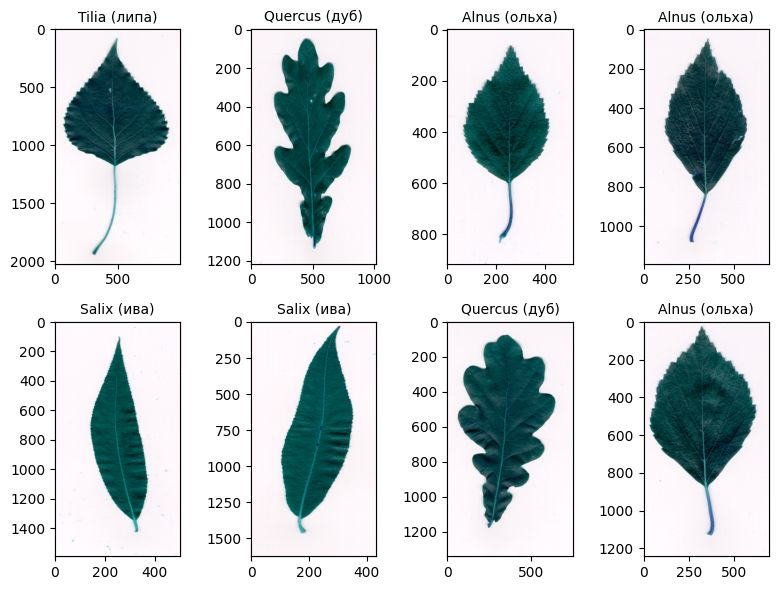

In [97]:
class_names = ['Quercus (дуб)', 'Alnus (ольха)', 'Salix (ива)', 'Tilia (липа)']
plot_images(train_images, train_labels, class_names)

Выполните преобразование изображений обучающей и тестовой выборок во временные ряды с помощью функции `image2ts()`.  

In [98]:
# INSERT YOUR CODE
angle_step = 20
visualize = False
def images2ts(images,angle_step=angle_step,visualize=visualize):
  ts_list=[]
  converter = Image2TimeSeries(angle_step)
  for img in images:
    ts = converter.convert(img, visualize)
    ts_list.append(ts)
  return np.array(ts_list)

train_ts=images2ts(train_images,angle_step=angle_step,visualize=visualize)
test_ts=images2ts(test_images,angle_step=angle_step,visualize=visualize)

print("Размер train_ts",train_ts.shape)
print("Размер test_ts",test_ts.shape)

Размер train_ts (60, 18)
Размер test_ts (40, 18)


Для классификации временных рядов методом $k$ ближайших соседей вам необходимо использовать класс `TimeSeriesKNN` из модуля *classification.py*.
Реализуйте метод `fit()` в классе `TimeSeriesKNN`, который выполняет поиск для каждого элемента из тестовой выборки $k$ ближайших соседей и назначает им тот класс, который является часто встречающимся среди классов ближайших соседей. В качестве параметров в метод `fit()` передается тестовая выборка. Вычислите точность классификации по метрике accuracy с помощью функции `calculate_accurary()` из модуля *classification.py*.

In [99]:
n_neighbors = 6
metric = 'euclidean'
metric_params = {'normalize': True}

# INSERT YOUR CODE
knn_ed = TimeSeriesKNN(n_neighbors=n_neighbors, metric=metric, metric_params=metric_params)
knn_ed.fit(train_ts,train_labels)
y_ped_ed = knn_ed.predict(test_ts)

acc_ed=calculate_accuracy(test_labels,y_ped_ed)
print("Точность acc_ed : ", acc_ed)


Точность acc_ed :  0.8


In [100]:
metric = 'dtw'
metric_params = {'normalize': True}

# INSERT YOUR CODE
knn_dtw = TimeSeriesKNN(n_neighbors=n_neighbors, metric=metric, metric_params=metric_params)
knn_dtw.fit(train_ts,train_labels)
y_ped_dtw = knn_dtw.predict(test_ts)

acc_dtw=calculate_accuracy(test_labels,y_ped_dtw)
print("Точность acc_dtw : ", acc_dtw)

Точность acc_dtw :  0.775


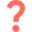
Проанализируйте результаты и сделайте выводы.

*# WRITE YOUR ANSWER*

В результате анализа производительности двух различных метрик для алгоритма KNN на временных рядах можно сделать следующие выводы:

1. **Метрика Евклида** (Euclidean Distance):
   - Точность: **0.8** (или 80%).
   - Это говорит о том, что модель, использующая евклидово расстояние, имеет достаточно высокую производительность в классификации временных рядов.

2. **Метрика Динамического Временного Упрощения** (Dynamic Time Warping, DTW):
   - Точность: **0.775** (или 77.5%).
   - Хотя эта метрика более подходящая для временных рядов, в данном случае она показала немного худшую производительность по сравнению с евклидовой метрикой.

### Выводы:

- **Евклидово расстояние**: В данном случае эта простая метрика показала лучший результат при классификации временных рядов. Это может означать, что временные ряды исследуемого набора данных существенно не изменяются по форме, и простое пространственное измерение даёт хорошие результаты.

- **DTW**: Несмотря на свою теоретическую мощь в обработке временных рядов, данный метод оказался менее эффективным в данном конкретном сценарии. Возможно, причина заключается в особенностях данных или в том, что параметры DTW (например, нормализация) не были оптимально настроены.